<a href="https://colab.research.google.com/github/PPatrickGU/ROB311/blob/master/TP4_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROB311 TP4** 

### **Implementation of the algorithm of SVM to identify the handwriting number** 

*Author: Yan CHEN & Dajing GU*

In [19]:
import pandas as pd
import numpy as np
import itertools
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

### **Useful function**

In [20]:
def data_loading(path):
    dataset = pd.read_csv(path)
    data = dataset.iloc[:, 1:]
    label = dataset.iloc[:, 0]
    return data, label

# Reference : https://blog.csdn.net/u012193416/article/details/79469770
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
        print("Normalized confusion matrix")
    else:
        title = 'Confusion matrix without normalization'
        print('Confusion matrix without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment='top',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()  

def getAccuracy(testSet, predictions):
  correct = 0
  for x in range(testSet.shape[0]):
    if testSet[x] == predictions[x]:
      correct += 1
  print("\n Accuracy: %.2f%% \n" %float(correct/len(predictions)*100))

def getResult(prediction_label, test_label):
    cm = confusion_matrix(test_label, prediction_label)
    print("classification report : ", "\n", classification_report(test_label, prediction_label))
    print("\n", "confusion matrix:", "\n", cm, "\n")
    getAccuracy(prediction_label, test_label)
    label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plot_confusion_matrix(cm, classes=label_names, normalize=True)



### **Data loading**

In [21]:
train_path = "./mnist_train.csv"
test_path = "./mnist_test.csv"
train_data, train_target = data_loading(train_path)
test_data, test_target = data_loading(test_path)


### **I）A simple implementation of the algorithm**


In [22]:
pca = PCA(n_components=100)
print("data size before PCA:", train_data.shape)
pca.fit(train_data)
train_data_PCA = pca.transform(train_data)
test_data_PCA = pca.transform(test_data)
print('data size after PCA: ' ,train_data_PCA.shape)

data size before PCA: (60000, 784)
data size after PCA:  (60000, 100)


classification report :  
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


 confusion matrix: 
 [[ 974    0    1    0    0    2    0    1    2    0]
 [   0 1128    3    1    0    1    1    0    1    0]
 [   5    0 1014    0    1    0    1    7    4    0]
 [   0    0    2  996    0    3  

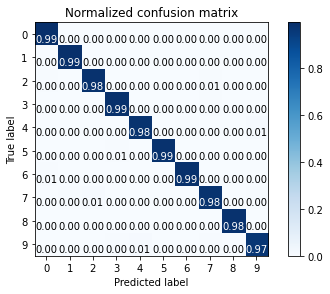

In [23]:
clf = SVC()
clf.fit(train_data_PCA, train_target)
prediction = clf.predict(test_data_PCA)
getResult(prediction, test_target)

### **II) A better implementation using make_pipeline**

classification report :  
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


 confusion matrix: 
 [[ 973    0    1    1    0    0    3    0    2    0]
 [   0 1124    2    1    1    2    2    1    2    0]
 [   1    2 1014    1    1    0    1    3    8    1]
 [   0    0    7  986    0    6  

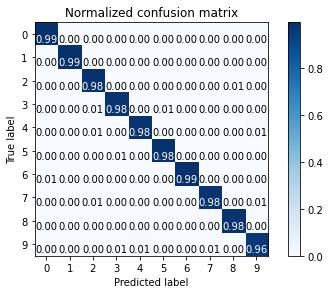

In [24]:
pca = PCA(n_components=100, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, StandardScaler(), svc)
model.fit(train_data, train_target)
prediction = model.predict(test_data)
getResult(prediction, test_target)

### **III) A try with the grid_search**

In [27]:
def svm_test(test_path, clf):
    test_data, test_label = data_loading(test_path)
    prediction_label = clf.predict(test_data)
    return prediction_label, test_label

def svm_train_pca(train_path, svc_kernel = 'rbf', gridsearchcv = False):
    train_data, train_label = data_loading(train_path)
    pca = PCA(n_components=100, whiten=True)
    svc = SVC(kernel=svc_kernel, class_weight='balanced')
    clf = make_pipeline(pca, svc)
    if gridsearchcv == True:
        parameters = {'svc__kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'svc__C':[1, 10]}
        clf = GridSearchCV(clf, parameters)
        clf.fit(train_data, train_label)
        print("The best parameters and best score: \n", clf.best_params_, clf.best_score_)
    else:
        clf.fit(train_data, train_label)
    return clf


**Train**

In [28]:
clf = svm_train_pca(train_path, gridsearchcv=True)

The best parameters and best score: 
 {'svc__C': 10, 'svc__kernel': 'rbf'} 0.97955


**Test and Result**

classification report :  
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


 confusion matrix: 
 [[ 974    0    1    1    0    0    2    0    2    0]
 [   0 1127    3    1    1    1    1    0    1    0]
 [   2    1 1014    1    1    0    1    4    7    1]
 [   0    0    7  987    0    5  

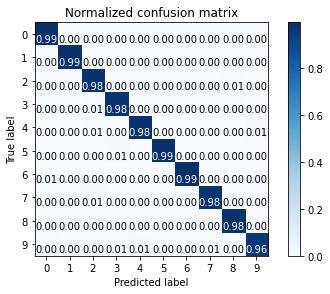

In [29]:
prediction, test_label = svm_test(test_path, clf)
getResult(prediction, test_label)